In [1]:
import torch
import numpy as np
from datasets import load_dataset
from scipy.linalg import orthogonal_procrustes
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader

# Set device (models are loaded on CPU; TransformerLens moves them to device)
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# Cell 4: Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -------------------------------
# Cell 5: Load IMDb dataset and filter a small validation subset for analysis
dataset = load_dataset("imdb")

def filter_by_label(dataset_split, label, max_samples=50):
    filtered = [d for d in dataset_split if d["label"] == label]
    return filtered[:max_samples]

# We use the 'test' split for analysis
val_data = dataset["test"]
pos_samples = filter_by_label(val_data, 1, max_samples=50)
neg_samples = filter_by_label(val_data, 0, max_samples=50)
print(f"Positive samples: {len(pos_samples)}, Negative samples: {len(neg_samples)}")

# Combine texts from positive and negative samples
texts = [s["text"] for s in pos_samples + neg_samples]
print(f"Total texts for activation extraction: {len(texts)}")

# -------------------------------
# Define a function to load a model and wrap with TransformerLens
def load_tl_model(model_path):
    hf_model = AutoModelForCausalLM.from_pretrained(model_path)
    hf_model.config.pad_token_id = tokenizer.pad_token_id
    tl_model = HookedTransformer.from_pretrained(
        "gpt2",      # recognized alias for GPT-2
        hf_model=hf_model,
        device=device
    )
    tl_model.eval()
    return tl_model

# Define model paths (using your sample style)
model_paths = {
    "base": "gpt2",                     # Base model from Hugging Face
    "3126": "./results/checkpoint-3126", # Finetuned checkpoint at epoch 3126
}

# Load models
base_model = load_tl_model(model_paths["base"])
finetuned_model = load_tl_model(model_paths["3126"])

# -------------------------------
# Define batched activation extraction functions using hooks

def extract_activation_batched(model, texts, layer_num, batch_size=10):
    """Extracts activations for a given layer in batches to save GPU memory.
    The activations are averaged over the token dimension (residual pre-activations).
    """
    activations = []
    # Use the appropriate hook name (e.g., for residual pre-activation)
    hook_name = f"blocks.{layer_num}.hook_resid_pre"
    
    def hook_fn(res, hook):
        # res shape: (batch, sequence_length, hidden_dim)
        # Compute average over tokens and append to our list
        activations.append(res.mean(dim=1).detach().cpu())
    
    hooks = [(hook_name, hook_fn)]
    
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        with torch.no_grad():
            _ = model.run_with_hooks(batch_texts, fwd_hooks=hooks)
        # Clear cache between batches
        torch.cuda.empty_cache()
    
    # Concatenate all batch activations (each of shape [batch_size, hidden_dim])
    return torch.cat(activations, dim=0).numpy()

def extract_final_activation_batched(model, texts, batch_size=10):
    final_layer = model.cfg.n_layers - 1
    return extract_activation_batched(model, texts, final_layer, batch_size=batch_size)

# -------------------------------
# Extract activations in batches for each model
print("Extracting activations for the base model...")
base_layer9 = extract_activation_batched(base_model, texts, layer_num=9, batch_size=10)
base_final = extract_final_activation_batched(base_model, texts, batch_size=10)

print("Extracting activations for the finetuned model (3126)...")
finetuned_layer9 = extract_activation_batched(finetuned_model, texts, layer_num=9, batch_size=10)
finetuned_final = extract_final_activation_batched(finetuned_model, texts, batch_size=10)

# -------------------------------
# Procrustes Alignment Analysis

# For Layer 9 representations:
R_layer9, scale_layer9 = orthogonal_procrustes(finetuned_layer9, base_layer9)
finetuned_layer9_aligned = finetuned_layer9.dot(R_layer9) * scale_layer9
error_layer9 = np.linalg.norm(base_layer9 - finetuned_layer9_aligned, 'fro')
print("Procrustes error for Layer 9 representations:", error_layer9)

# For Final Hidden State representations:
R_final, scale_final = orthogonal_procrustes(finetuned_final, base_final)
finetuned_final_aligned = finetuned_final.dot(R_final) * scale_final
error_final = np.linalg.norm(base_final - finetuned_final_aligned, 'fro')
print("Procrustes error for Final Hidden State representations:", error_final)


Positive samples: 50, Negative samples: 50
Total texts for activation extraction: 100
Loaded pretrained model gpt2 into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer
Extracting activations for the base model...
Extracting activations for the finetuned model (3126)...
Procrustes error for Layer 9 representations: 1013822660.0
Procrustes error for Final Hidden State representations: 8484809700.0


In [2]:
!pip install pot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 104.5 MB/s eta 0:00:00


In [3]:
import ot
import numpy as np

def gw_alignment(X_base, X_finetuned):
    """
    Computes the Gromov-Wasserstein distance between two sets of representations.
    X_base: numpy array of shape (n_samples, d)
    X_finetuned: numpy array of shape (n_samples, d)
    
    Returns:
      gw_distance: the GW distance (scalar)
      log: a log dictionary from POT with additional details.
    """
    # Compute pairwise squared Euclidean distance matrices for each set
    D_base = ot.dist(X_base, X_base, metric='euclidean') ** 2
    D_finetuned = ot.dist(X_finetuned, X_finetuned, metric='euclidean') ** 2
    
    n = X_base.shape[0]
    # Uniform weights on the samples
    p = np.ones(n) / n
    q = np.ones(n) / n
    
    # Compute GW distance using squared loss; log=True returns additional info.
    gw_distance, log = ot.gromov.gromov_wasserstein2(
        D_finetuned, D_base, p, q, loss_fun='square_loss', log=True
    )
    return gw_distance, log

# --- Assuming you have already extracted activations ---
# Variables:
#    base_layer9, finetuned_layer9  : representations from layer 9 (numpy arrays)
#    base_final, finetuned_final    : representations from final hidden state

# Compute GW alignment for layer 9 representations
gw_distance_layer9, log_layer9 = gw_alignment(base_layer9, finetuned_layer9)
print("Gromov-Wasserstein distance for Layer 9 representations:", gw_distance_layer9)

# Compute GW alignment for final hidden state representations
gw_distance_final, log_final = gw_alignment(base_final, finetuned_final)
print("Gromov-Wasserstein distance for Final Hidden State representations:", gw_distance_final)


Gromov-Wasserstein distance for Layer 9 representations: 179437.97688850295
Gromov-Wasserstein distance for Final Hidden State representations: 810213.3351535274


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Step 1: Load IMDb Test Dataset
# -----------------------------
test_dataset = load_dataset("imdb", split="test")
sample_size = 200  # Adjust as needed
test_subset = test_dataset.select(range(sample_size))

# -----------------------------
# Step 2: Load Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -----------------------------
# Step 3: Define the classification function that plugs in final hidden state
# -----------------------------
def classify_review_plugged(base_model, finetuned_model, tokenizer, review_text):
    """
    Creates a prompt from the review text, computes the final hidden state using the finetuned model,
    plugs that hidden state into the base model's LM head to compute logits, and then returns 1 if the logit
    for " positive" is higher than for " negative", else returns 0.
    """
    prompt = f"Review: {review_text} Sentiment:"
    # Encode the prompt with truncation (max_length=1024)
    input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    
    # Get final hidden state from the finetuned model
    with torch.no_grad():
        finetuned_outputs = finetuned_model(input_ids, output_hidden_states=True, return_dict=True)
        # Extract the final hidden state (shape: [batch, seq_len, hidden_dim])
        hidden_state = finetuned_outputs.hidden_states[-1]
    
    # Plug the final hidden state into the base model's LM head
    with torch.no_grad():
        # The lm_head expects a tensor of shape [batch, seq_len, hidden_dim] and returns logits [batch, seq_len, vocab_size]
        logits = base_model.lm_head(hidden_state)
    
    # Use the logits of the last token
    logits = logits[0, -1, :]
    
    # Candidate tokens (with a leading space) for " positive" and " negative"
    pos_ids = tokenizer.encode(" positive", add_special_tokens=False)
    neg_ids = tokenizer.encode(" negative", add_special_tokens=False)
    
    vocab_size = logits.size(0)
    pos_log_prob = logits[pos_ids[0]].item() if pos_ids and pos_ids[0] < vocab_size else float("-inf")
    neg_log_prob = logits[neg_ids[0]].item() if neg_ids and neg_ids[0] < vocab_size else float("-inf")
    
    return 1 if pos_log_prob > neg_log_prob else 0

# -----------------------------
# Step 4: Define Evaluation Function
# -----------------------------
def evaluate_plugged(base_model, finetuned_model, tokenizer, dataset):
    correct = 0
    total = 0
    for example in tqdm.tqdm(dataset, desc="Evaluating"):
        review_text = example["text"]
        true_label = example["label"]  # 0 for negative, 1 for positive
        try:
            pred_label = classify_review_plugged(base_model, finetuned_model, tokenizer, review_text)
        except Exception as e:
            print("Error processing review; defaulting to label 0:", e)
            pred_label = 0
        correct += int(pred_label == true_label)
        total += 1
    return correct / total if total > 0 else 0

# -----------------------------
# Step 5: Load Base and Finetuned Models (with output_hidden_states enabled)
# -----------------------------
print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2", output_hidden_states=True)
base_model.config.pad_token_id = base_model.config.eos_token_id
base_model.to(device)
base_model.eval()

print("Loading Finetuned Model...")
finetuned_model_path = "./results/checkpoint-3126"  
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path, output_hidden_states=True)
finetuned_model.config.pad_token_id = finetuned_model.config.eos_token_id
finetuned_model.to(device)
finetuned_model.eval()

# -----------------------------
# Step 6: Evaluate the Plugged Model Accuracy
# -----------------------------
plugged_accuracy = evaluate_plugged(base_model, finetuned_model, tokenizer, test_subset)
print(f"Plugged Model Accuracy: {plugged_accuracy * 100:.2f}%")


Using device: cuda
Loading Base Model...
Loading Finetuned Model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Evaluating: 100%|██████████| 200/200 [00:03<00:00, 59.13it/s]

Plugged Model Accuracy: 95.00%


Using device: cuda


Loading Base Model...
Loading Finetuned Model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Number of transformer blocks: 12


Evaluating: 100%|██████████| 200/200 [00:10<00:00, 18.75it/s]


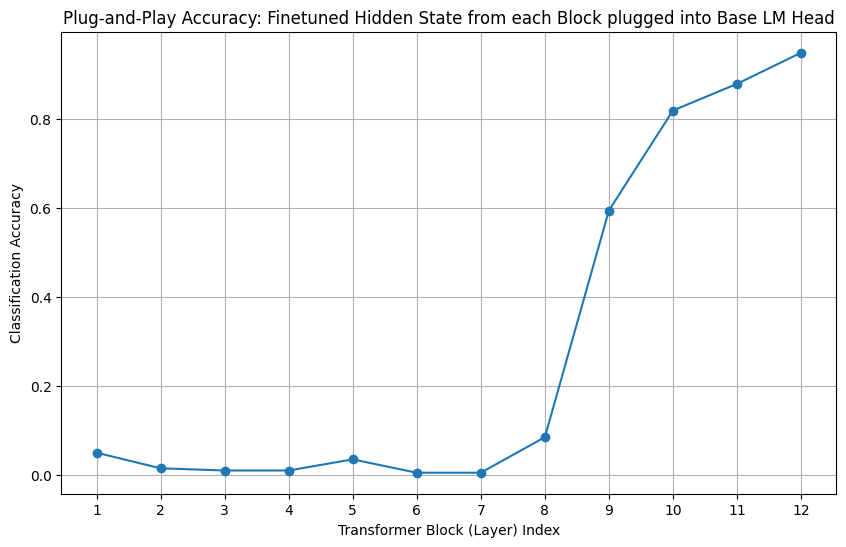

Layer 1: Accuracy = 5.00%
Layer 2: Accuracy = 1.50%
Layer 3: Accuracy = 1.00%
Layer 4: Accuracy = 1.00%
Layer 5: Accuracy = 3.50%
Layer 6: Accuracy = 0.50%
Layer 7: Accuracy = 0.50%
Layer 8: Accuracy = 8.50%
Layer 9: Accuracy = 59.50%
Layer 10: Accuracy = 82.00%
Layer 11: Accuracy = 88.00%
Layer 12: Accuracy = 95.00%


In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Step 1: Load IMDb Test Dataset (a small subset for speed)
# -----------------------------
test_dataset = load_dataset("imdb", split="test")
sample_size = 200  # You can adjust this sample size
test_subset = test_dataset.select(range(sample_size))

# -----------------------------
# Step 2: Load Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -----------------------------
# Step 3: Load Base and Finetuned Models with output_hidden_states enabled
# -----------------------------
print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2", output_hidden_states=True)
base_model.config.pad_token_id = base_model.config.eos_token_id
base_model.to(device)
base_model.eval()

print("Loading Finetuned Model...")
finetuned_model_path = "./results/checkpoint-3126"  # Adjust to your checkpoint directory
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path, output_hidden_states=True)
finetuned_model.config.pad_token_id = finetuned_model.config.eos_token_id
finetuned_model.to(device)
finetuned_model.eval()

# -----------------------------
# Step 4: Define a function to get predictions from each transformer block
# -----------------------------
def classify_review_all_layers(base_model, finetuned_model, tokenizer, review_text):
    """
    For a given review text, this function constructs a prompt,
    passes it through the finetuned model to obtain hidden states for all layers,
    and then for each block (transformer layer) plugs its output into the base model's LM head.
    
    It returns a list of predictions (0 or 1), one for each transformer block.
    We assume that when output_hidden_states=True, the returned tuple has length (num_hidden_layers + 1),
    with index 0 = input embeddings, and indices 1,...,num_hidden_layers = block outputs.
    """
    prompt = f"Review: {review_text} Sentiment:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    
    with torch.no_grad():
        # Get all hidden states from the finetuned model.
        outputs = finetuned_model(input_ids, output_hidden_states=True, return_dict=True)
    hidden_states = outputs.hidden_states  # Tuple of length num_hidden_layers+1
    
    # We'll use each block's output (i.e. indices 1 to num_hidden_layers) for plug-and-play.
    predictions = []
    # Candidate tokens for classification (note the leading space)
    pos_ids = tokenizer.encode(" positive", add_special_tokens=False)
    neg_ids = tokenizer.encode(" negative", add_special_tokens=False)
    
    # Loop over each transformer block's output
    for layer_idx in range(1, len(hidden_states)):
        h = hidden_states[layer_idx]  # shape: [1, seq_len, hidden_dim]
        # Plug h into the base model's LM head
        with torch.no_grad():
            logits = base_model.lm_head(h)  # shape: [1, seq_len, vocab_size]
        # Use logits from the last token
        last_logits = logits[0, -1, :]
        vocab_size = last_logits.size(0)
        pos_logit = last_logits[pos_ids[0]].item() if pos_ids and pos_ids[0] < vocab_size else float("-inf")
        neg_logit = last_logits[neg_ids[0]].item() if neg_ids and neg_ids[0] < vocab_size else float("-inf")
        pred = 1 if pos_logit > neg_logit else 0
        predictions.append(pred)
    return predictions

# -----------------------------
# Step 5: Evaluate accuracy layer-by-layer on test subset
# -----------------------------
# Determine number of transformer blocks using the correct attribute
n_blocks = finetuned_model.config.num_hidden_layers  # Use 'num_hidden_layers'
print(f"Number of transformer blocks: {n_blocks}")

# We'll accumulate per-layer correct counts.
correct_counts = [0] * n_blocks
total_count = 0

for example in tqdm.tqdm(test_subset, desc="Evaluating"):
    review_text = example["text"]
    true_label = example["label"]  # 0 for negative, 1 for positive
    try:
        preds = classify_review_all_layers(base_model, finetuned_model, tokenizer, review_text)
    except Exception as e:
        print("Error processing review; skipping. Error:", e)
        continue
    # preds is a list of length n_blocks with predictions for each block.
    for i, pred in enumerate(preds):
        if pred == true_label:
            correct_counts[i] += 1
    total_count += 1

# Compute accuracy for each block
layer_accuracies = [correct / total_count for correct in correct_counts]

# -----------------------------
# Step 6: Plot the accuracy per transformer block
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_blocks + 1), layer_accuracies, marker='o')
plt.xlabel("Transformer Block (Layer) Index")
plt.ylabel("Classification Accuracy")
plt.title("Plug-and-Play Accuracy: Finetuned Hidden State from each Block plugged into Base LM Head")
plt.xticks(range(1, n_blocks + 1))
plt.grid(True)
plt.show()

# Print accuracies for reference
for i, acc in enumerate(layer_accuracies, start=1):
    print(f"Layer {i}: Accuracy = {acc * 100:.2f}%")


Using device: cuda
Loading Base Model...
Loading Finetuned Model...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.10it/s]


Base Model Accuracy: 45.50%
Number of transformer blocks (layers): 12

Evaluating with layer 1 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.03it/s]


Layer 1 replaced accuracy: 47.50%

Evaluating with layer 2 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.31it/s]


Layer 2 replaced accuracy: 46.00%

Evaluating with layer 3 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.08it/s]


Layer 3 replaced accuracy: 41.00%

Evaluating with layer 4 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.96it/s]


Layer 4 replaced accuracy: 50.50%

Evaluating with layer 5 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.81it/s]


Layer 5 replaced accuracy: 51.00%

Evaluating with layer 6 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.06it/s]


Layer 6 replaced accuracy: 50.00%

Evaluating with layer 7 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.60it/s]


Layer 7 replaced accuracy: 63.00%

Evaluating with layer 8 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.54it/s]


Layer 8 replaced accuracy: 61.50%

Evaluating with layer 9 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.51it/s]


Layer 9 replaced accuracy: 59.00%

Evaluating with layer 10 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.65it/s]


Layer 10 replaced accuracy: 57.50%

Evaluating with layer 11 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.50it/s]


Layer 11 replaced accuracy: 56.00%

Evaluating with layer 12 replaced...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 78.84it/s]


Layer 12 replaced accuracy: 41.00%


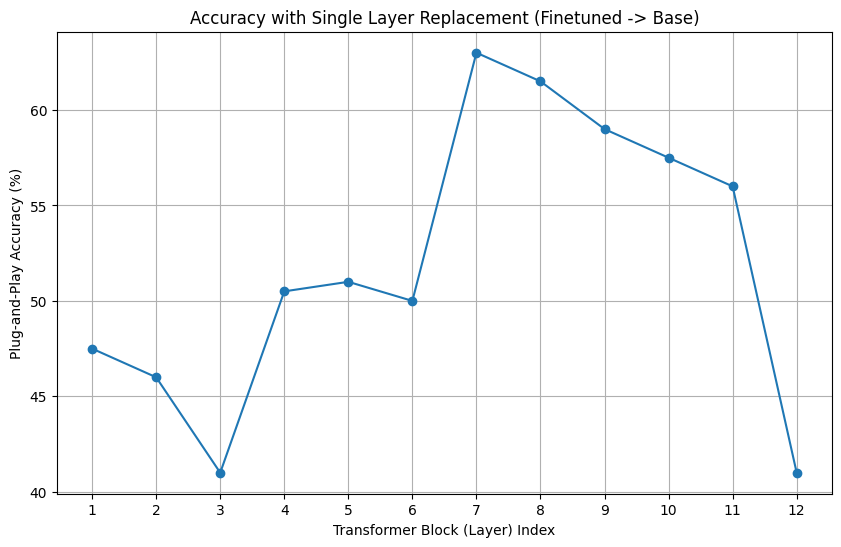

Layer 1: Accuracy = 47.50%
Layer 2: Accuracy = 46.00%
Layer 3: Accuracy = 41.00%
Layer 4: Accuracy = 50.50%
Layer 5: Accuracy = 51.00%
Layer 6: Accuracy = 50.00%
Layer 7: Accuracy = 63.00%
Layer 8: Accuracy = 61.50%
Layer 9: Accuracy = 59.00%
Layer 10: Accuracy = 57.50%
Layer 11: Accuracy = 56.00%
Layer 12: Accuracy = 41.00%


In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import tqdm
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Step 1: Load IMDb Test Dataset (small subset for speed)
# -----------------------------
test_dataset = load_dataset("imdb", split="test")
sample_size = 200  # Adjust as needed
test_subset = test_dataset.select(range(sample_size))

# -----------------------------
# Step 2: Load Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -----------------------------
# Step 3: Define classification function
# -----------------------------
def classify_review(model, tokenizer, review_text):
    """
    Given a review text, constructs a prompt and returns a sentiment prediction:
      1 if the logit for " positive" is higher than for " negative",
      else 0.
    """
    prompt = f"Review: {review_text} Sentiment:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits[0, -1, :]  # logits for the last token
    
    # Get candidate token ids (with a leading space)
    pos_ids = tokenizer.encode(" positive", add_special_tokens=False)
    neg_ids = tokenizer.encode(" negative", add_special_tokens=False)
    
    vocab_size = logits.size(0)
    pos_log_prob = logits[pos_ids[0]].item() if pos_ids and pos_ids[0] < vocab_size else float("-inf")
    neg_log_prob = logits[neg_ids[0]].item() if neg_ids and neg_ids[0] < vocab_size else float("-inf")
    
    return 1 if pos_log_prob > neg_log_prob else 0

# -----------------------------
# Step 4: Define evaluation function
# -----------------------------
def evaluate_model(model, tokenizer, dataset):
    correct = 0
    total = 0
    for example in tqdm.tqdm(dataset, desc="Evaluating"):
        review_text = example["text"]
        true_label = example["label"]  # 0 for negative, 1 for positive
        try:
            pred_label = classify_review(model, tokenizer, review_text)
        except Exception as e:
            print("Error processing review:", e)
            pred_label = 0
        if pred_label == true_label:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0

# -----------------------------
# Step 5: Load Base and Finetuned Models
# -----------------------------
print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
base_model.config.pad_token_id = base_model.config.eos_token_id
base_model.to(device)
base_model.eval()

print("Loading Finetuned Model...")
finetuned_model_path = "./results/checkpoint-3126"  # Update this path as needed
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path)
finetuned_model.config.pad_token_id = finetuned_model.config.eos_token_id
finetuned_model.to(device)
finetuned_model.eval()

# -----------------------------
# Step 6: Evaluate the Base Model for reference
# -----------------------------
base_accuracy = evaluate_model(base_model, tokenizer, test_subset)
print(f"Base Model Accuracy: {base_accuracy * 100:.2f}%")

# -----------------------------
# Step 7: For each layer, replace the base model's layer with the corresponding finetuned model's layer, then evaluate.
# -----------------------------
num_layers = base_model.config.num_hidden_layers  # GPT-2 uses "num_hidden_layers"
print(f"Number of transformer blocks (layers): {num_layers}")

layer_accuracies = []

for i in range(num_layers):
    print(f"\nEvaluating with layer {i+1} replaced...")
    # Create a deep copy of the base model
    new_model = copy.deepcopy(base_model)
    # Replace layer i in the new_model with the corresponding layer from the finetuned model.
    new_model.transformer.h[i] = copy.deepcopy(finetuned_model.transformer.h[i])
    new_model.to(device)
    new_model.eval()
    
    acc = evaluate_model(new_model, tokenizer, test_subset)
    layer_accuracies.append(acc)
    print(f"Layer {i+1} replaced accuracy: {acc * 100:.2f}%")
    
    # Clean up GPU memory between iterations
    del new_model
    torch.cuda.empty_cache()

# -----------------------------
# Step 8: Plot the per-layer accuracy
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_layers+1), [acc*100 for acc in layer_accuracies], marker='o')
plt.xlabel("Transformer Block (Layer) Index")
plt.ylabel("Plug-and-Play Accuracy (%)")
plt.title("Accuracy with Single Layer Replacement (Finetuned -> Base)")
plt.xticks(range(1, num_layers+1))
plt.grid(True)
plt.show()

# Print per-layer accuracies
for i, acc in enumerate(layer_accuracies, start=1):
    print(f"Layer {i}: Accuracy = {acc * 100:.2f}%")


In [1]:
import torch
import numpy as np
import ot  # pip install pot
from datasets import load_dataset
from scipy.linalg import orthogonal_procrustes
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader

# Set device (models are loaded on CPU; TransformerLens moves them to device)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -------------------------------
# Load tokenizer
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -------------------------------
# Load IMDb dataset and filter a small validation subset for analysis
# -------------------------------
dataset = load_dataset("imdb")

def filter_by_label(dataset_split, label, max_samples=50):
    filtered = [d for d in dataset_split if d["label"] == label]
    return filtered[:max_samples]

# We use the 'test' split for analysis
val_data = dataset["test"]
pos_samples = filter_by_label(val_data, 1, max_samples=50)
neg_samples = filter_by_label(val_data, 0, max_samples=50)
print(f"Positive samples: {len(pos_samples)}, Negative samples: {len(neg_samples)}")

# Combine texts from positive and negative samples
texts = [s["text"] for s in pos_samples + neg_samples]
print(f"Total texts for activation extraction: {len(texts)}")

# -------------------------------
# Define a function to load a model and wrap with TransformerLens
# -------------------------------
def load_tl_model(model_path):
    hf_model = AutoModelForCausalLM.from_pretrained(model_path)
    hf_model.config.pad_token_id = tokenizer.pad_token_id
    tl_model = HookedTransformer.from_pretrained(
        "gpt2",      # recognized alias for GPT-2
        hf_model=hf_model,
        device=device
    )
    tl_model.eval()
    return tl_model

# Define model paths
model_paths = {
    "base": "gpt2",                     # Base model from Hugging Face
    "3126": "./results/checkpoint-3126", # Finetuned checkpoint at epoch 3126
}

# Load models
base_model = load_tl_model(model_paths["base"])
finetuned_model = load_tl_model(model_paths["3126"])

# -------------------------------
# Define batched activation extraction functions (for final hidden states)
# -------------------------------
def extract_activation_batched(model, texts, layer_num, batch_size=10):
    activations = []
    hook_name = f"blocks.{layer_num}.hook_resid_pre"
    
    def hook_fn(res, hook):
        activations.append(res.mean(dim=1).detach().cpu())
    
    hooks = [(hook_name, hook_fn)]
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        with torch.no_grad():
            _ = model.run_with_hooks(batch_texts, fwd_hooks=hooks)
        torch.cuda.empty_cache()
    
    return torch.cat(activations, dim=0).numpy()

def extract_final_activation_batched(model, texts, batch_size=10):
    final_layer = model.cfg.n_layers - 1
    return extract_activation_batched(model, texts, final_layer, batch_size=batch_size)

# Extract final hidden state activations for both models
print("Extracting final hidden state activations for the base model...")
base_final = extract_final_activation_batched(base_model, texts, batch_size=10)
print("Extracting final hidden state activations for the finetuned model...")
finetuned_final = extract_final_activation_batched(finetuned_model, texts, batch_size=10)

# -------------------------------
# Compare Final Hidden States using Procrustes Analysis
# -------------------------------
R_final, scale_final = orthogonal_procrustes(finetuned_final, base_final)
finetuned_final_aligned = finetuned_final.dot(R_final) * scale_final
error_final = np.linalg.norm(base_final - finetuned_final_aligned, 'fro')
print("Procrustes error for Final Hidden State representations:", error_final)

# -------------------------------
# Compare LM Head (Linear Projection) Weights using the 'unembed' attribute
# -------------------------------
def compare_lm_head_weights(base_model, finetuned_model):
    # In TransformerLens, the unembed object stores its weight in W_U.
    base_head = base_model.unembed.W_U.data.cpu().numpy()
    finetuned_head = finetuned_model.unembed.W_U.data.cpu().numpy()
    # Use Procrustes to align finetuned LM head weights to base LM head weights.
    R_head, scale_head = orthogonal_procrustes(finetuned_head, base_head)
    finetuned_head_aligned = finetuned_head.dot(R_head) * scale_head
    error_head = np.linalg.norm(base_head - finetuned_head_aligned, 'fro')
    return error_head

# Then, in your main code:
lm_head_error = compare_lm_head_weights(base_model, finetuned_model)
print("Procrustes error for LM Head (unembed) weights:", lm_head_error)


# -------------------------------
# Also, compare using Gromov-Wasserstein (GW) distance for final hidden states
# -------------------------------
def gw_alignment(X, Y):
    D_X = ot.dist(X, X, metric='euclidean') ** 2
    D_Y = ot.dist(Y, Y, metric='euclidean') ** 2
    n = X.shape[0]
    p = np.ones(n) / n
    q = np.ones(n) / n
    gw_distance, log = ot.gromov.gromov_wasserstein2(
        D_Y, D_X, p, q, loss_fun='square_loss', log=True
    )
    return gw_distance, log

gw_distance_final, log_final = gw_alignment(base_final, finetuned_final)
print("Gromov-Wasserstein distance for Final Hidden State representations:", gw_distance_final)


Using device: cuda
Positive samples: 50, Negative samples: 50
Total texts for activation extraction: 100
Loaded pretrained model gpt2 into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer
Extracting final hidden state activations for the base model...
Extracting final hidden state activations for the finetuned model...
Procrustes error for Final Hidden State representations: 8484809700.0
